In [3]:
import os
import cv2
import math
import numpy as np
import imageio
import torch
import torchvision
import pytorch3d as p3d
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import ball_query, knn_points, knn_gather, sample_farthest_points
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    AmbientLights,
    RasterizationSettings,
    MeshRendererWithFragments,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights,
    MeshRenderer
)
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from collections import OrderedDict

In [16]:
class Multiface():
    def __init__(self, root='/data/multiface', entity='m--20180227--0000--6795937--GHS', actions=['E057_Cheeks_Puffed'], resolution=1024, interval=3):
        super(Multiface, self).__init__()
        if not os.path.exists(root):
            raise Exception('incorrect root path')
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            torch.cuda.set_device(self.device)
        else:
            raise Exception('gpu unavailable')
        
        self.root = root
        self.resolution = resolution
        self.entity = entity
        self.actions = actions
        self.chosen_timings = OrderedDict()
        for act in actions:
            self.chosen_timings[act] = self.parse_time(act, interval=interval)
    
    
    def parse_time(self, action, interval=3):
        timings = []
        _dir = os.path.join(self.root, self.entity, 'tracked_mesh', action)
        for p in Path(_dir).glob('*.obj'):
            timing = os.path.split(str(p))[-1].split('.')[0]
            timings.append(timing)
        timings.sort()
        chosen_timings = []
        if interval >= len(timings):
            chosen_timings.append(timings[0])
        else:
            for i in range(0, len(timings), interval):
                chosen_timings.append(timings[i])
        return chosen_timings
        
    def generate_source_rgbd(self, out_dir, source_views=[300, 12, -12, 15]):
        dist, elev_up, elev_down, azim = source_views
        sv_1 = [dist, elev_up, 0]
        sv_2 = [dist, elev_down, -azim]
        sv_3 = [dist, elev_down, azim]
        
        for act in self.actions:
            _dir = os.path.join(out_dir, act)
            if not os.path.exists(_dir):
                os.makedirs(_dir, exist_ok=True)
            print('saving {} source view RGBDs ...'.format(act))
            for t in tqdm(self.chosen_timings[act]):
                _dir = os.path.join(out_dir, act, t)
                if not os.path.exists(_dir):
                    os.makedirs(_dir, exist_ok=True)
                obj, verts, tex = self.load_obj(act, t)
                mesh = self.create_mesh(obj=obj, verts=verts, tex=tex)

                sv1_color, sv1_depth, sv1_camera = m.mesh2rgbd(mesh, dist=dist, elev=elev_up, azim=0)
                sv2_color, sv2_depth, sv2_camera = m.mesh2rgbd(mesh, dist=dist, elev=elev_down, azim=-azim)
                sv3_color, sv3_depth, sv3_camera = m.mesh2rgbd(mesh, dist=dist, elev=elev_down, azim=azim)
                
                np.save(os.path.join(_dir, 'sv1_color.npy'), sv1_color)
                np.save(os.path.join(_dir, 'sv1_depth.npy'), sv1_depth)
                np.save(os.path.join(_dir, 'sv2_color.npy'), sv2_color)
                np.save(os.path.join(_dir, 'sv2_depth.npy'), sv2_depth)
                np.save(os.path.join(_dir, 'sv3_color.npy'), sv3_color)
                np.save(os.path.join(_dir, 'sv3_depth.npy'), sv3_depth)
    
    def create_mesh(self, obj, verts, tex):
        """
        Args:
            maps: (N, H, W, C)
            faces_uvs: (N, F, 3) LongTensor, index into verts_uvs
            verts_uvs: (N, V, 2) FloatTensor, uv coordinates of each vetex
            
        """
        faces_uvs = obj['uv_ids']
        verts_uvs = obj['uvs']
        faces = obj['vert_ids']
    
        faces_uvs = torch.LongTensor(faces_uvs).unsqueeze(0).to(self.device)
        verts_uvs = torch.FloatTensor(verts_uvs).unsqueeze(0).to(self.device)
        tex = torch.FloatTensor(tex).unsqueeze(0).to(self.device)
        faces = torch.LongTensor(faces).unsqueeze(0).to(self.device)
        
        verts_mean = np.mean(verts, axis=0)
        verts -= verts_mean
        verts = torch.FloatTensor(verts).unsqueeze(0).to(self.device)

        texture = TexturesUV(tex, faces_uvs, verts_uvs)
        mesh = Meshes(verts, faces, texture)
        return mesh
    
    
    def mesh2rgbd(self, mesh, dist=240, elev=0, azim=0, znear=1, zfar=800):        
        R, T = look_at_view_transform(dist, elev, azim)
        cameras = FoVPerspectiveCameras(zfar=zfar, R=R, T=T, device=self.device)
        raster_settings = RasterizationSettings(
            image_size=self.resolution,
            blur_radius=0.0,
            faces_per_pixel=1
        )
        lights = AmbientLights(device=self.device)
        renderer = MeshRendererWithFragments(
            rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings).to(self.device),
            shader=SoftPhongShader(cameras=cameras, lights=lights).to(self.device)
        )

        color, fragments = renderer(mesh)
        depth = fragments.zbuf
        color = color[0, ..., :3].cpu().numpy() * 255
        color = color.astype(int)
        depth = depth[0, ..., :3].cpu().numpy()[:, :, 0]
        return color, depth, cameras
    
    
    def rgbd2cloud(self, color, depth, cameras):        
        mask = (depth >= 0)
        y_mat = np.arange(self.resolution)[:, None].repeat(self.resolution, axis=1).astype(np.float32)
        y_mat = - y_mat * 2 / (self.resolution - 1) + 1
        x_mat = y_mat.T
        xy_depth = np.stack([x_mat, y_mat, depth], axis=2)
        xy_depth = xy_depth[mask, :]
        feats = color[mask, :]

        xy_depth = torch.FloatTensor(xy_depth).unsqueeze(0).to(self.device)
        feats = torch.FloatTensor(feats).unsqueeze(0).to(self.device)
        points = cameras.unproject_points(xy_depth, scaled_depth_input=False, world_coordinates=True, in_ndc=True)
        cloud = Pointclouds(points=points, features=feats)
        return cloud
    
    def cloud2rgb(self, cloud, dist=240, elev=0, azim=0, znear=1, zfar=800):
        R, T = look_at_view_transform(dist, elev, azim)
        cameras = FoVPerspectiveCameras(zfar=zfar, R=R, T=T, device=self.device)

        raster_settings = PointsRasterizationSettings(
            image_size=self.resolution,
            radius=0.003,
            points_per_pixel=10
        )
        rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
        compositor = NormWeightedCompositor(background_color=(255, 255, 255))
        renderer = PointsRenderer(
            rasterizer=rasterizer,
            compositor=compositor
        ).to(self.device)

        color = renderer(cloud)[0, ..., :3].cpu().numpy().astype(int)
        return color
    
    def load_obj(self, action, timing):
        tex_path = os.path.join(self.root, self.entity, 'unwrapped_uv_1024', action, 'average', '{}.png'.format(timing))
        obj_path = os.path.join(self.root, self.entity, 'tracked_mesh', action, '{}.obj'.format(timing))
        bin_path = os.path.join(os.path.split(obj_path)[0], '{}.bin'.format(timing))     
        
        vertices = []
        faces_vertex, faces_uv = [], []
        uvs = []
        with open(obj_path, "r") as f:
            for s in f:
                l = s.strip()
                if len(l) == 0:
                    continue
                parts = l.split(" ")
                if parts[0] == "vt":
                    uvs.append([float(x) for x in parts[1:]])
                elif parts[0] == "v":
                    vertices.append([float(x) for x in parts[1:]])
                elif parts[0] == "f":
                    faces_vertex.append([int(x.split("/")[0]) for x in parts[1:]])
                    faces_uv.append([int(x.split("/")[1]) for x in parts[1:]])
        obj = {
            "verts": np.array(vertices, dtype=np.float32),
            "uvs": np.array(uvs, dtype=np.float32),
            "vert_ids": np.array(faces_vertex, dtype=np.int32) - 1,
            "uv_ids": np.array(faces_uv, dtype=np.int32) - 1,
        }
        verts = np.fromfile(bin_path, dtype=np.float32).reshape((-1, 3))
        tex = cv2.imread(tex_path).astype(np.float32)[..., ::-1] / 255.
        tex = cv2.resize(tex, (self.resolution, self.resolution))
        return obj, verts, tex
    
    def normalize(self, target, mode='depth', zfar=800, denormalize=False):
        if mode == 'depth':
            if not denormalize:
                mask = (target == 255)
                target = target.astype(np.float32) * zfar / 255.
                target[mask] = -1
            else:
                mask = (target == -1)
                target = 255 * target / zfar
                target[mask] = 255
                
        elif model == 'color':
            if not denormalize:
                target = target.astype(np.float32) / 255.
            else:
                target *= 255
                target = target.astype(np.int32)
        else:
            raise Exception('mode:{} unrecognizable'.format(mode))
        return target
    
    

In [17]:
m = Multiface(root='/home/tungi/datasets/multiface', entity='m--20180227--0000--6795937--GHS', actions=['E057_Cheeks_Puffed'], resolution=512)
m.generate_source_rgbd('/home/tungi/conferencing-main/data/source', source_views=[300, 12, -12, 15])

saving E057_Cheeks_Puffed source view RGBDs ...


  0%|          | 0/17 [00:00<?, ?it/s]

In [21]:
m = Multiface(root='/home/tungi/datasets/multiface', entity='m--20180227--0000--6795937--GHS', actions=['E057_Cheeks_Puffed'], resolution=512)

color_1 = np.load('/home/tungi/conferencing-main/data/source/E057_Cheeks_Puffed/021897/sv1_color.npy')
depth_1 = np.load('/home/tungi/conferencing-main/data/source/E057_Cheeks_Puffed/021897/sv1_depth.npy')
color_2 = np.load('/home/tungi/conferencing-main/data/source/E057_Cheeks_Puffed/021897/sv2_color.npy')
depth_2 = np.load('/home/tungi/conferencing-main/data/source/E057_Cheeks_Puffed/021897/sv2_depth.npy')
color_3 = np.load('/home/tungi/conferencing-main/data/source/E057_Cheeks_Puffed/021897/sv3_color.npy')
depth_3 = np.load('/home/tungi/conferencing-main/data/source/E057_Cheeks_Puffed/021897/sv3_depth.npy')

device = torch.device("cuda:0")
R, T = look_at_view_transform(300, 12, 0)
camera_1 = FoVPerspectiveCameras(zfar=800, R=R, T=T, device=device)
R, T = look_at_view_transform(300, -12, -15)
camera_2 = FoVPerspectiveCameras(zfar=800, R=R, T=T, device=device)
R, T = look_at_view_transform(300, -12, 15)
camera_3 = FoVPerspectiveCameras(zfar=800, R=R, T=T, device=device)

cloud_1 = m.rgbd2cloud(color_1, depth_1, camera_1)
cloud_2 = m.rgbd2cloud(color_2, depth_2, camera_2)
cloud_3 = m.rgbd2cloud(color_3, depth_3, camera_3)

In [39]:
points_1 = cloud_1.points_list()[0]
points_2 = cloud_2.points_list()[0]
points_3 = cloud_3.points_list()[0]
points_all = torch.cat((points_1, points_2, points_3), 0).unsqueeze(0)

feat_1 = cloud_1.features_list()[0]
feat_2 = cloud_2.features_list()[0]
feat_3 = cloud_3.features_list()[0]
feats_all = torch.cat((feat_1, feat_2, feat_3), 0).unsqueeze(0)

sampled_points, idx = sample_farthest_points(points_all, K=2000)
dist, idx = knn_points(sampled_points, points_all, K=50)

sampled_points = torch.index_select(points_all[0], 0, idx[0]).unsqueeze(0)
sampled_feats = torch.index_select(feats_all[0], 0, idx[0]).unsqueeze(0)
fused_cloud = Pointclouds(points=sampled_points, features=sampled_feats)

Text(0.5, 1.0, 'source3')

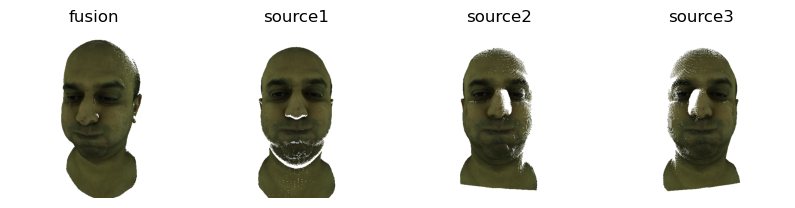

In [46]:
view_1 = m.cloud2rgb(cloud_1, dist=300, elev=0, azim=0)
view_2 = m.cloud2rgb(cloud_2, dist=300, elev=0, azim=0)
view_3 = m.cloud2rgb(cloud_3, dist=300, elev=0, azim=0)

fused_view = m.cloud2rgb(fused_cloud, dist=300, elev=12, azim=15)

fig, axis = plt.subplots(1, 4, figsize=(10,20))
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')
axis[3].axis('off')

axis[0].imshow(fused_view)
axis[0].set_title('fusion')
axis[1].imshow(view_1)
axis[1].set_title('source1')
axis[2].imshow(view_2)
axis[2].set_title('source2')
axis[3].imshow(view_3)
axis[3].set_title('source3')